In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import sys
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import os
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'

In [2]:
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)

root = os.path.join(onedrive_path, 'CODES', 'samples', 'cifar10_data')

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


cifar10_train = datasets.CIFAR10(root=root, download=True, train=True, transform=transform)
cifar10_test = datasets.CIFAR10(root=root, download=True, train=False, transform=transform)

train_dataloader = DataLoader(cifar10_train, batch_size=100, shuffle=True)
test_dataloader = DataLoader(cifar10_test, batch_size=100, shuffle=False)



Files already downloaded and verified
Files already downloaded and verified


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cpu


In [4]:

def split_into_kernels(image, kernel_size):

    b, c, h, w = image.shape
    assert (h % kernel_size == 0) and (w % kernel_size == 0), "Image size must be divisible by kernel size"
    patches = image.unfold(2, kernel_size, kernel_size).unfold(3, kernel_size, kernel_size)
    patches = patches.contiguous().view(b, c, -1, kernel_size, kernel_size)
    patches = patches.permute(0, 2, 1, 3, 4)
    return patches



In [5]:

class Encoder(nn.Module):
    def __init__(self, kernel_size, leverage, channels):
        super(Encoder, self).__init__()
        self.kernel_size = kernel_size
        self.leverage = leverage

        # 入力次元: c * (k*k)
        kernel_in = (kernel_size ** 2) * channels
        self.kernel_in = kernel_in
        # 出力次元: kernel_in / leverage
        self.output_dim = int(kernel_in / leverage)

        # ランダムな位相の複素行列 B を作成
        phase = torch.rand(self.output_dim, kernel_in) * 2 * np.pi - np.pi
        modulus = torch.ones(self.output_dim, kernel_in)
        real_part = modulus * torch.cos(phase)
        imag_part = modulus * torch.sin(phase)

        
        self.B = torch.complex(real_part, imag_part).detach().to(device)
        self.B.requires_grad = False

        self.alpha = torch.rand(kernel_in) * 0.5 + 0.5  #<<<<<<<<<<<<<<<
        self.alpha = self.alpha.detach().to(device)
        self.alpha.requires_grad = False

    def forward(self, x):
        """
        xの形状: (b, n_patches, c, k, k)
        """
        b, n_patches, c, kh, kw = x.shape
        
        x = x.reshape(b * n_patches, c * kh * kw)
        x = torch.exp(1j * self.alpha * x) 
        x = x.T 
        x = torch.matmul(self.B, x)
        x = x.T
        x = torch.abs(x) ** 2  
        return x , n_patches
    

In [6]:
class CNN(nn.Module):
    def __init__(self, in_channels,n_patches):
        super(CNN, self).__init__()
        side = int(np.sqrt(n_patches))
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * side//4 * side//4, 256)
        self.fc2 = nn.Linear(256, 10)

        self.func = nn.ReLU()

    def forward(self, x):
        # conv1 → ReLU → pool
        x = self.pool(self.func(self.conv1(x)))
        # conv2 → ReLU → pool
        x = self.pool(self.func(self.conv2(x)))
        # フラット化
        x = x.view(x.size(0), -1)
        x = self.func(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
#DPE
class EncoderClassifier(nn.Module):
    def __init__(self, img_size, channels, kernel_size, leverage):
        super(EncoderClassifier, self).__init__()
        self.img_size = img_size
        self.channels = channels
        self.kernel_size = kernel_size
        self.leverage = leverage

        kernel_in = channels * kernel_size ** 2
        feat_dim = int(kernel_in / leverage)
        n_patches = (img_size // kernel_size) * (img_size // kernel_size)

        self.split = split_into_kernels
        self.encoder1 = Encoder(kernel_size, leverage, channels)
        self.encoder2 = Encoder(kernel_size, leverage, channels)
        self.bn = nn.BatchNorm2d(feat_dim)  # CNNのためにBatchNorm2dに変更
        self.classifier = CNN(feat_dim,n_patches)  # CNNの入力チャネル数をfeat_dimに変更

    def forward(self, x):
        b = x.size(0)
        x = x.view(b, self.channels, self.img_size, self.img_size)
        x = self.split(x, self.kernel_size)
        x1, n_patches = self.encoder1(x)
        x2, n_patches = self.encoder2(x)
        x = x1 - x2#<<<<<<<<<<<<<<<<<<<<<<<<<<
        x = x.view(b, n_patches, -1)
        side = int(np.sqrt(n_patches))
        x = x.view(b, side, side, -1).permute(0, 3, 1, 2) 
        x = self.bn(x)
        x = self.classifier(x)
        return x

1/5th Time Epoch: 20/20

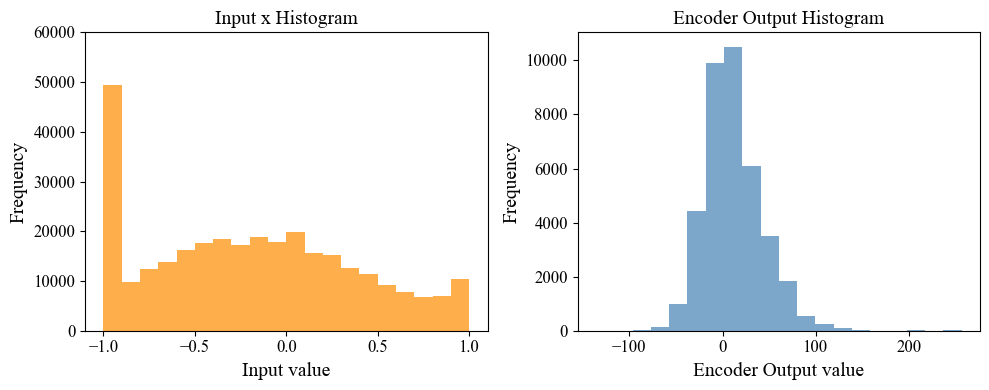

Test Accuracy: 56.89%
loss_train: 1.1981,loss_test: 1.2100
LOSS:1.2100
ProcessingTime: 283.5874762535095


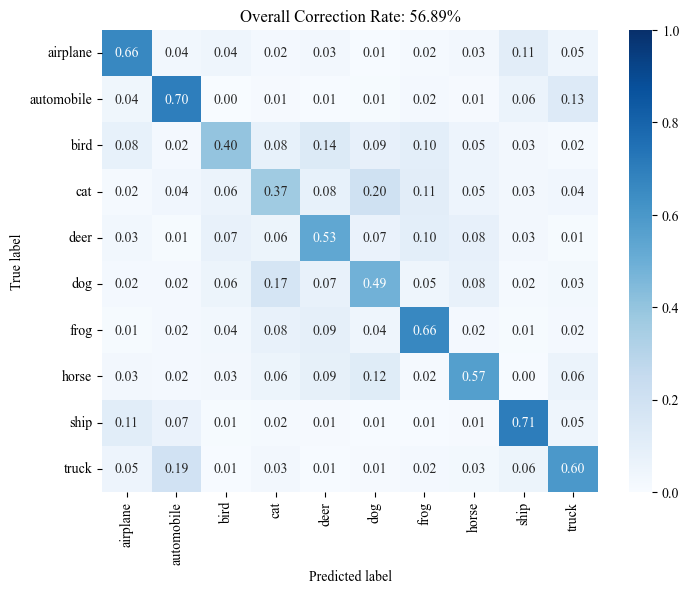

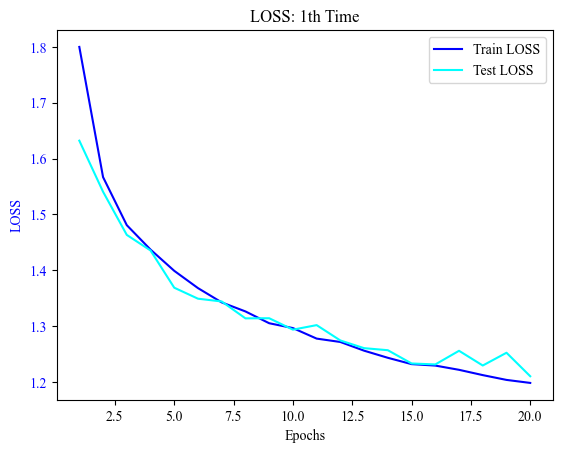

2/5th Time Epoch: 20/20

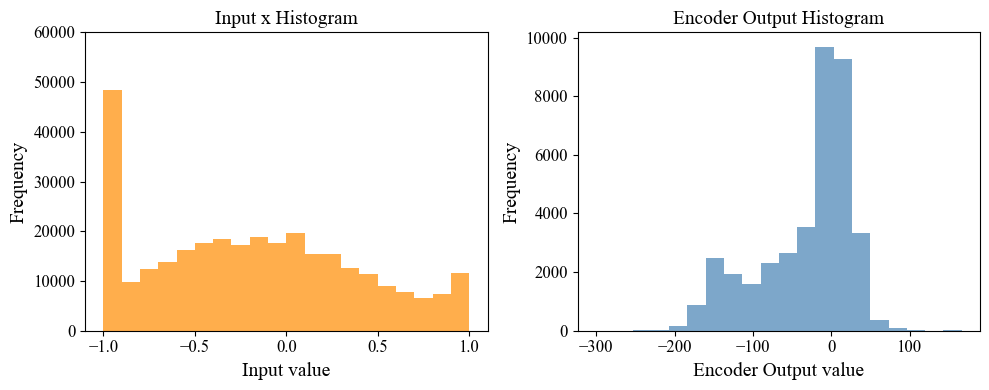

Test Accuracy: 59.10%
loss_train: 1.1221,loss_test: 1.1500
LOSS:1.1500
ProcessingTime: 356.72906255722046


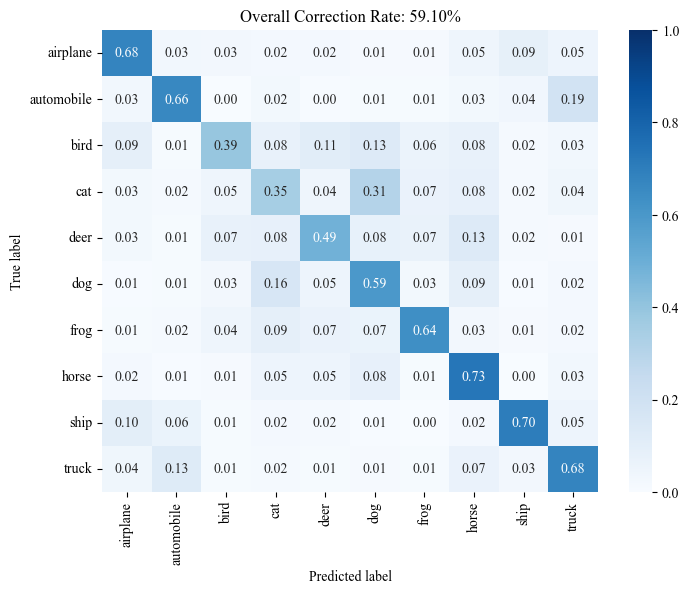

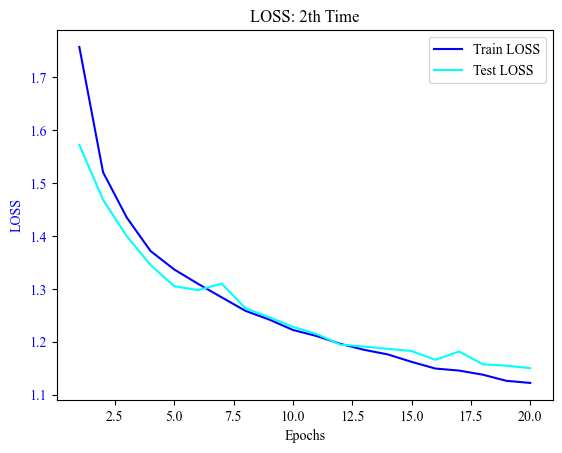

3/5th Time Epoch: 20/20

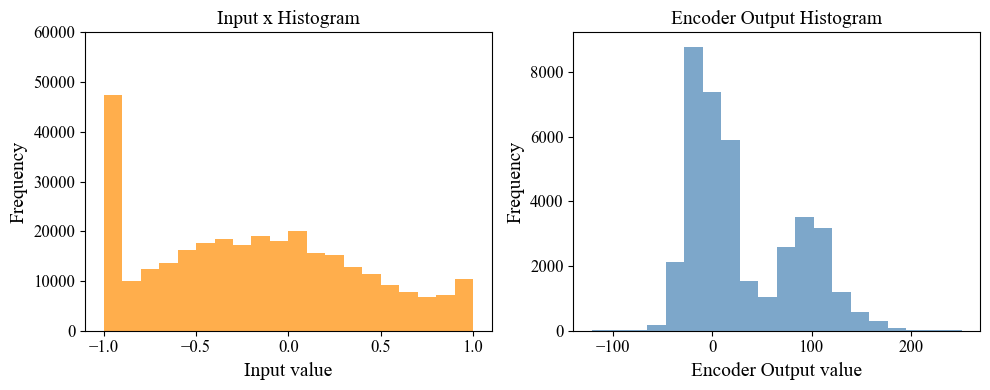

Test Accuracy: 58.65%
loss_train: 1.1335,loss_test: 1.1775
LOSS:1.1775
ProcessingTime: 371.6432785987854


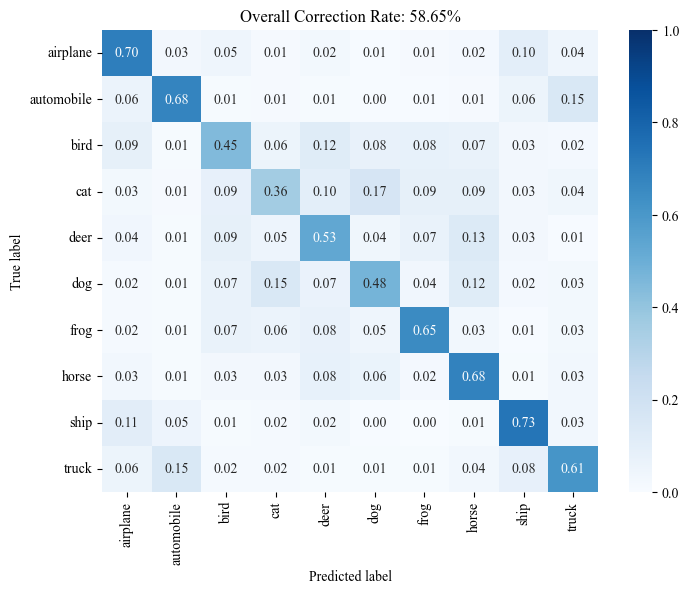

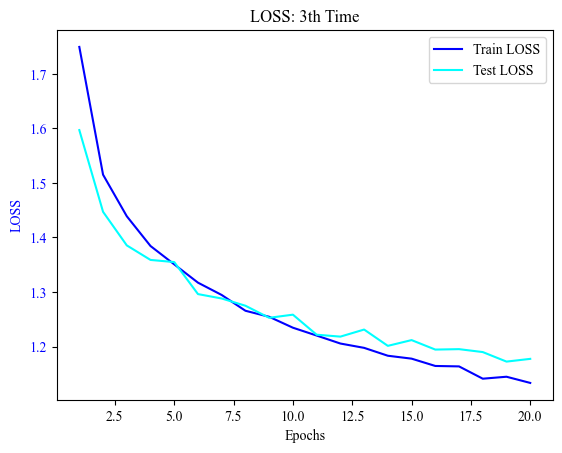

4/5th Time Epoch: 20/20

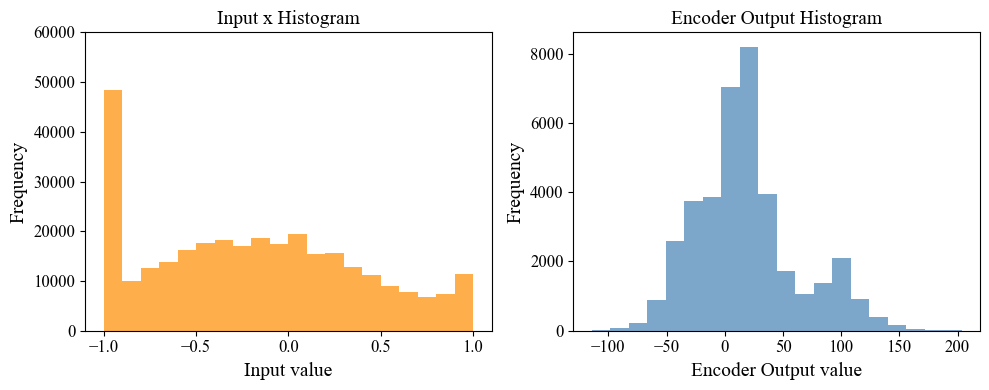

Test Accuracy: 59.43%
loss_train: 1.1081,loss_test: 1.1321
LOSS:1.1321
ProcessingTime: 508.6756417751312


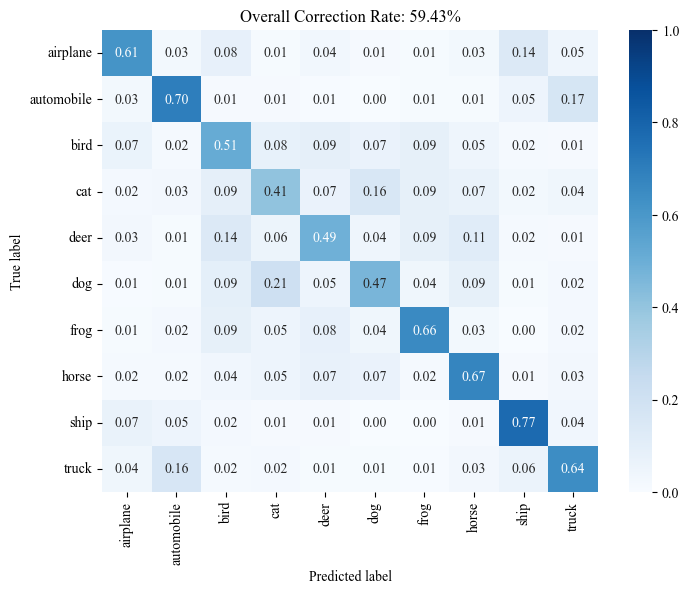

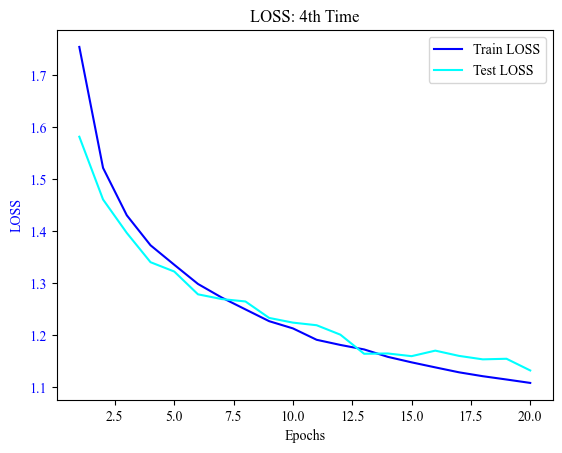

5/5th Time Epoch: 20/20

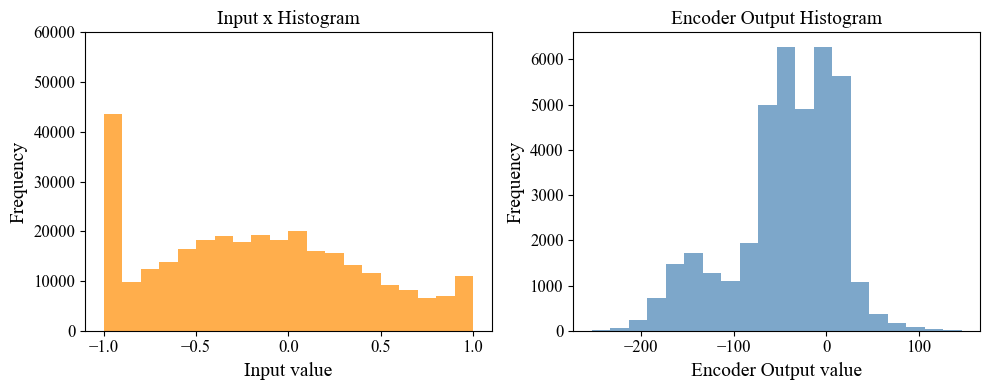

Test Accuracy: 58.65%
loss_train: 1.1110,loss_test: 1.1517
LOSS:1.1517
ProcessingTime: 507.48614168167114


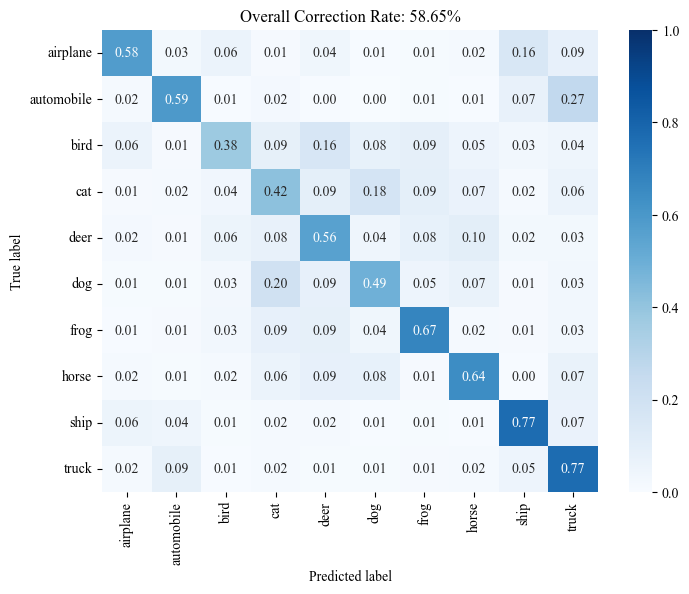

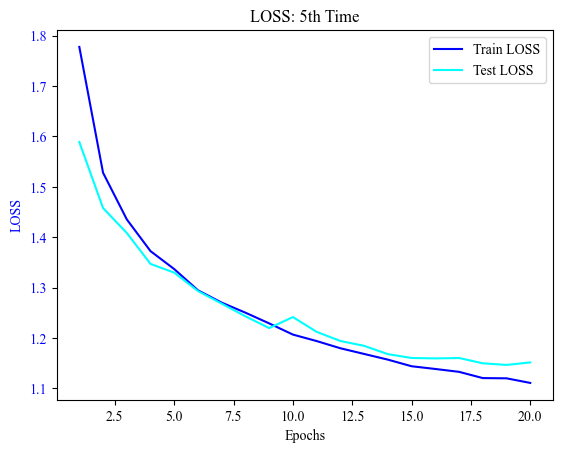

In [8]:
channels = 3
img_size = 32
leverage = 8
kernel_size = 4

max_epochs = 20##10

num_try = 5##5

All_last_loss = []
All_loss_test = []
All_pro_time = []
All_test_acc = []

for num_times in range(num_try): 

    model = EncoderClassifier(img_size,channels, kernel_size, leverage).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    loss_train_ = []
    loss_test_ = []
    pro_time_ = []

            
    for epoch in range(max_epochs):

        sys.stderr.write('\r%d/%dth Time Epoch: %d/%d' % (num_times+1,num_try, epoch+1, max_epochs)) 
        sys.stderr.flush()

        loss_train = 0
        loss_test = 0

        start_time1 = time.time()
        for (x,t) in train_dataloader:
                    
            x, t = x.to(device), t.to(device)
            y = model(x).to(device)
            loss = criterion(y, t) 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

       
        loss_train_avg = loss_train / len(train_dataloader)
        end_time1 = time.time()
        pro_time_.append(end_time1-start_time1)

        model.eval()
        with torch.no_grad():
            all_preds = []
            all_labels = []
            correct = 0
            total = 0
            first_batch = True
            for x, t in test_dataloader:
                x, t = x.to(device), t.to(device)
                y = model(x).to(device)
                _, predicted = torch.max(y, 1)
                loss = criterion(y,t)
                loss_test += loss.item()        
                total += t.size(0)
                correct += (predicted == t).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(t.cpu().numpy()) 

                if epoch == max_epochs - 1:
                    if first_batch:
                        x_splitted = model.split(x, kernel_size)
                        x_in_flat = x_splitted.reshape(-1).detach().cpu().numpy()
                        x_encoded1, _ = model.encoder1(x_splitted)
                        x_encoded2, _ = model.encoder2(x_splitted)
                        x_encoded = x_encoded1 - x_encoded2
                        x_out_flat = x_encoded.reshape(-1).detach().cpu().numpy()

                        # サブプロットで横に並べて表示
                        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

                        # 入力ヒストグラム
                        axes[0].hist(x_in_flat, bins=20, color='darkorange', alpha=0.7)
                        axes[0].set_xlabel("Input value", fontsize=14)
                        axes[0].set_ylabel("Frequency", fontsize=14)
                        axes[0].set_title("Input x Histogram", fontsize=14)
                        axes[0].tick_params(labelsize=12)
                        axes[0].set_ylim(0,60000)

                        # エンコーダ出力ヒストグラム
                        axes[1].hist(x_out_flat, bins=20, color='steelblue', alpha=0.7)
                        axes[1].set_xlabel("Encoder Output value", fontsize=14)
                        axes[1].set_ylabel("Frequency", fontsize=14)
                        axes[1].set_title("Encoder Output Histogram", fontsize=14)
                        axes[1].tick_params(labelsize=12)

                        plt.tight_layout()
                        plt.show()

                        first_batch = False

        #print(f"Test Accuracy: {100 * correct / total:.2f}%")
        loss_test_avg = loss_test / len(test_dataloader)

        loss_train_.append(loss_train_avg)
        loss_test_.append(loss_test_avg)
        #if epoch == max_epochs-1:
    All_loss_test.append(loss_test_)
    All_pro_time.append(sum(pro_time_)) 

    cm = confusion_matrix(all_labels, all_preds)
    cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # 正規化（行ごとに割合に）

    Last_loss_test = loss_test_[-1]
    All_last_loss.append(Last_loss_test)
    Test_acc = 100 * correct / total
    All_test_acc.append(Test_acc)
    print(f"Test Accuracy: {Test_acc:.2f}%")
    print(f"loss_train: {loss_train_avg:.4f},loss_test: {loss_test_avg:.4f}")
    print(f"LOSS:{Last_loss_test:.4f}")
    print('ProcessingTime:',sum(pro_time_))
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names,vmin=0.0, vmax=1.0)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"Overall Correction Rate: {Test_acc:.2f}%")
    plt.show()

    fig, ax1 = plt.subplots()
    ax1.plot(range(1,len(loss_train_)+1), loss_train_, label="Train LOSS", color = 'blue')
    ax1.plot(range(1,len(loss_test_)+1), loss_test_, label="Test LOSS", color = 'cyan')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('LOSS', color = 'blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend()

    title = 'LOSS: %dth Time'%(num_times+1) #
    plt.title(title)
    plt.show()


In [15]:
import csv
ACC_mean = np.mean(All_test_acc)
ACC_best = np.max(All_test_acc)
ACC_bestID = np.argmax(All_test_acc)+1
ACC_worst = np.min(All_test_acc)
ACC_worstID = np.argmin(All_test_acc)+1

LOSS_mean = np.mean(All_last_loss)
LOSS_best = np.min(All_last_loss)
LOSS_bestID = np.argmin(All_last_loss)+1
LOSS_worst = np.max(All_last_loss)
LOSS_worstID = np.argmax(All_last_loss)+1

data = {
        "": ["ACC", "LOSS"],
    "Average": [ACC_mean, LOSS_mean],
    "Best ID": [ACC_bestID, LOSS_bestID],
    "Best": [ACC_best, LOSS_best],
    "Worst ID": [ACC_worstID, LOSS_worstID],
    "Worst": [ACC_worst, LOSS_worst],
}

df = pd.DataFrame(data)

print(df)


          Average  Best ID       Best  Worst ID      Worst
0   ACC  58.54400        4  59.430000         1  56.890000
1  LOSS   1.16425        4   1.132057         1   1.210013


In [ ]:
epochs = len(All_loss_test[0])  # エポック数（各リストの長さ）
num_dimensions = len(All_loss_test)  # 埋め込み次元数の数

# 各エポックごとに平均と標準偏差を計算
mean_loss = np.mean(All_loss_test, axis=0)
std_loss = np.std(All_loss_test, axis=0)

# グラフの描画
fig, ax1 = plt.subplots()

# 平均値の折れ線グラフと誤差範囲（標準偏差の誤差棒）
ax1.errorbar(
    x=range(1, epochs + 1), y=mean_loss, yerr=std_loss,
    fmt='-o', color='blue', ecolor='blue', capsize=5, 
)

# 軸ラベルやタイトルの設定
ax1.set_xlabel('Epochs')
ax1.set_ylabel('LOSS', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.title('LOSS Transition in Test data')
plt.ylim(1.0,2.0)
plt.show()

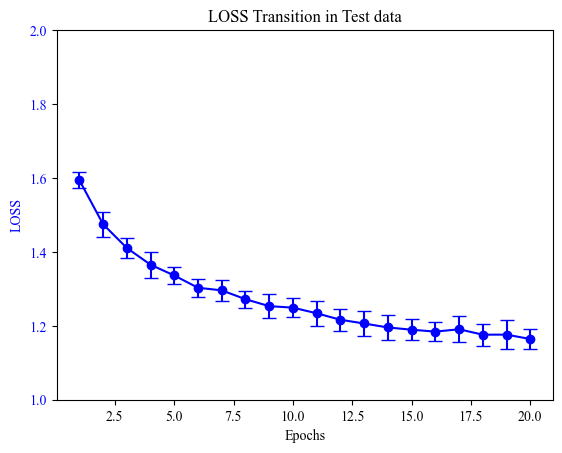

In [13]:
epochs = len(All_loss_test[0])  # エポック数（各リストの長さ）
num_dimensions = len(All_loss_test)  # 埋め込み次元数の数

# 各エポックごとに平均と標準偏差を計算
mean_loss = np.mean(All_loss_test, axis=0)
std_loss = np.std(All_loss_test, axis=0)

# グラフの描画
fig, ax1 = plt.subplots()

# 平均値の折れ線グラフと誤差範囲（標準偏差の誤差棒）
ax1.errorbar(
    x=range(1, epochs + 1), y=mean_loss, yerr=std_loss,
    fmt='-o', color='blue', ecolor='blue', capsize=5, 
)

# 軸ラベルやタイトルの設定
ax1.set_xlabel('Epochs')
ax1.set_ylabel('LOSS', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.title('LOSS Transition in Test data')
plt.ylim(1.0,2.0)
plt.show()

In [11]:
import csv
save_directory1 = os.path.join(onedrive_path,'CODES', 'konishi_Classifer', 'data','texts') 
print(save_directory1)
os.makedirs(save_directory1, exist_ok=True)
file_name = 'CNN_PM(DPE)_Class00_list.csv'##
full_path = os.path.join(save_directory1, file_name)
with open(full_path, mode='w', newline='') as file:
    writer = csv.writer(file)

    writer.writerow(All_loss_test)

/Users/konishi/OneDrive/CODES/konishi_Classifer/data/texts
